In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Feb 20 05:26:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    54W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
!pip -q install tensorflow tensorflow-gpu opencv-python matplotlib keras

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-exited-with-error
  
  × Running setup.py install for tensorflow-gpu did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Running setup.py install for tensorflow-gpu ... error
error: legacy-install-failure

× Encountered error while trying to install package.
╰─> tensorflow-gpu

note: This is an issue with the package mentioned above, not pip.
hint: See above for output from the failure.


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from keras import layers
import matplotlib
import pathlib
import cv2
import imghdr
import time
from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential, load_model # MAY NEED TO BE REPLACED W/ FUNCTIONAL API
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D
from keras.metrics import Precision, Recall, BinaryAccuracy
from PIL import Image

In [ ]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # stops gpu from running :(

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) # /OOM error

# 1

In [ ]:
size = 512
image_height, image_width = size, size
train_directory = 'drive/MyDrive/Colab Notebooks/Polyamanita/data/train_10'
image_extensions = ['jpg', 'jpeg', 'png'] # every file ends with jpg, but it's found to be a jpeg instead...

In [ ]:
epochs = 18 #60 #70
batch_size = 12 #16 #32

In [ ]:
def check_images():
    count = 0
    for folder in os.listdir(train_directory+'/'):
        for image in os.listdir(train_directory+'/'+folder+'/'): 
            count = count + 1
            img_path = train_directory+'/'+folder+'/'+image
            try: 
                img = cv2.imread(img_path)
                tip = imghdr.what(img_path)
                if tip not in image_extensions:
                    print(f'EXT: {img_path}')
                if img.shape != (size, size, 3):
                    print(f'SHP: {img_path}')
            except Exception as e:
                print(f'ERR: {img_path}\n{e}')
        print(count)
# check_images()        

In [ ]:
# Create data pipeline
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_directory, 
    validation_split=0.2, 
    subset="training", 
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size,
    # color_mode='rgba' # IMPORTANT FOR TRANSPARENT IMAGES (HAVE TO CHANGE SHAPE TO (size,size,4)!)
)

Found 5332 files belonging to 8 classes.
Using 4266 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size,
  # color_mode='rgba'
)


Found 5332 files belonging to 8 classes.
Using 1066 files for validation.


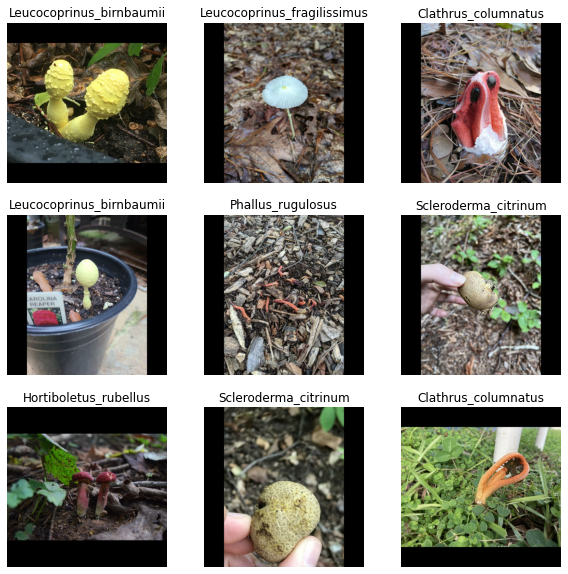

In [ ]:
class_names = train_ds.class_names

def show_batch():
    plt.figure(figsize=(10, 10))

    for images, labels in train_ds.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# show_batch()

In [ ]:
def show_size():
    for image_batch, labels_batch in train_ds:
      print(image_batch.shape)
      print(labels_batch.shape)
      break

# show_size()

(12, 1024, 1024, 3)
(12,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def auto_tuning():

    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# auto_tuning()

In [ ]:
normalization_layer = layers.Rescaling(1./255)
#normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

normalized_ds = train_ds.map(lambda x, y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# print(np.min(first_image), np.max(first_image))

scaled_iter = normalized_ds.as_numpy_iterator()
batch = scaled_iter.next()

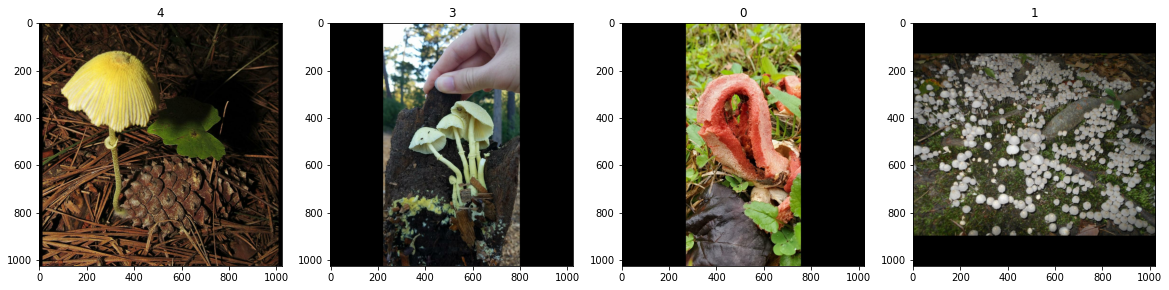

In [ ]:
# Context display
def show_batch(batch):
    figure, axis = plt.subplots(ncols=4, figsize=(20,20))
    for i, image in enumerate(batch[0][:4]):
        axis[i].imshow(image)
        axis[i].title.set_text(batch[1][i])
        
# show_batch(batch)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(size, size, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(
    optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 1024, 1024, 3)     0         
                                                                 
 conv2d (Conv2D)             (None, 1024, 1024, 16)    448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 512, 512, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 256, 256, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 64)      1

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=('horizontal'))#size,size,3)), #03-04
    layers.RandomRotation(0.2),#1),#03-04
    layers.RandomZoom(0.1),
  ]
)

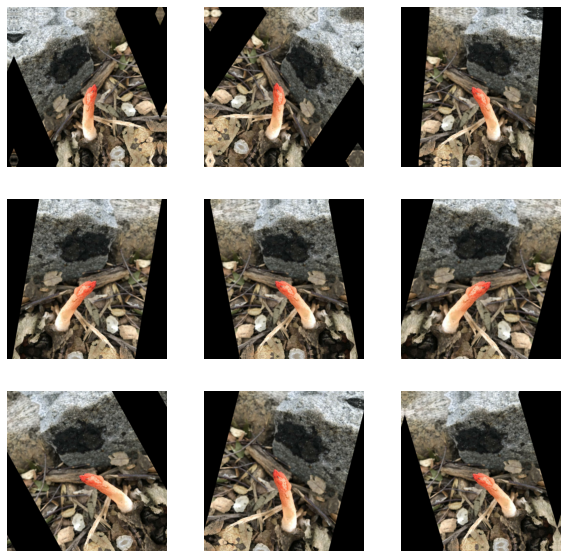

In [ ]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#   for i in range(9):
#     augmented_images = data_augmentation(images)
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_images[0].numpy().astype("uint8"))
#     plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# doesnt work now???
# model.summary()

In [ ]:
# ckpt_directory = 'drive/MyDrive/Colab Notebooks/Polyamanita/checkpoints/again'
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_directory,
#                                                  save_weights_only=True,
#                                                  verbose=1#,
#                                                  # save_freq=3*batch_size
# )

In [ ]:
print(f'Epochs: {epochs}\nBatch Size: {batch_size}\n')

Epochs: 18
Batch Size: 12



In [ ]:

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=batch_size,
  # callbacks=[cp_callback]
)

Epoch 1/18


356/356 [==============================] - 274s 728ms/step - loss: 2.2977 - accuracy: 0.2227 - val_loss: 1.6456 - val_accuracy: 0.3752
Epoch 2/18
356/356 [==============================] - 42s 119ms/step - loss: 1.4769 - accuracy: 0.4316 - val_loss: 1.4446 - val_accuracy: 0.4503
Epoch 3/18
356/356 [==============================] - 42s 119ms/step - loss: 1.3263 - accuracy: 0.4890 - val_loss: 1.3684 - val_accuracy: 0.4962
Epoch 4/18
356/356 [==============================] - 42s 118ms/step - loss: 1.2066 - accuracy: 0.5509 - val_loss: 1.1265 - val_accuracy: 0.5976
Epoch 5/18
356/356 [==============================] - 42s 119ms/step - loss: 1.1109 - accuracy: 0.5994 - val_loss: 1.1393 - val_accuracy: 0.5675
Epoch 6/18
356/356 [==============================] - 42s 118ms/step - loss: 0.9855 - accuracy: 0.6486 - val_loss: 1.0378 - val_accuracy: 0.6210
Epoch 7/18
356/356 [==============================] - 42s 118ms/step - loss: 0.8781 - accuracy: 0.6857 - val_loss: 1.1605 - val_accuracy: 0.

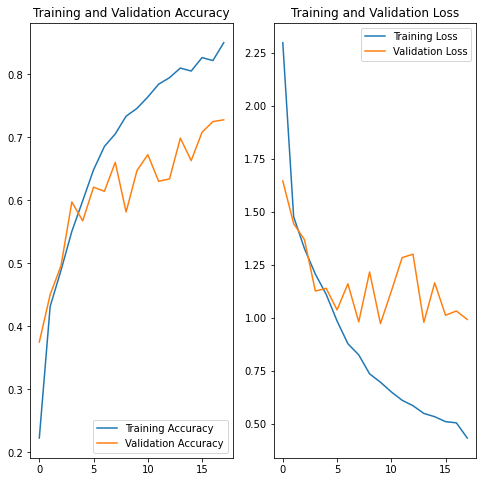

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model_save = model

In [ ]:
# checkpoint = 'drive/MyDrive/Colab Notebooks/Polyamanita/checkpoints/'
# for file in os.listdir(checkpoint):
#     os.remove(checkpoint + file)

In [ ]:
# i = 1
model_directory = 'drive/MyDrive/Colab Notebooks/Polyamanita/models/train_new'

In [ ]:
model.save(model_directory+'/savedmodel')

In [ ]:
model.save(model_directory+'/savedmodel.h5')

In [ ]:
os.listdir(model_directory)

['savedmodel', 'savedmodel.h5']